# Wireless localization with diffusion maps

Na pocetku cemo pozvati korisne pakete i definirati neke funkcije koje cemo koristit u ostatku

In [1]:
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import random
from munkres import Munkres
from munkres import Munkres, print_matrix

Funkcija koja računa običnu euklidsku udaljenost u vektorskom prostoru proizvoljne dimenzije

In [2]:
def euclidean_distance(pointA, pointB):
    n = len(pointA)
    res = 0
    for i in range(0, n):
        res = res + (pointA[i] - pointB[i]) ** 2
    res = res ** 0.5
    return res

Funkcija koja računa matricu udaljenosti D', tj. udaljenost između danih pozicija, kao argument prima numpy array sa koordinatama pozicija, a vraća matricu dimenzija (M, M) međusobnih udaljenosti

In [3]:
def position_distance(pozicije):
    M = np.shape(pozicije)[0]

    D_positions = np.zeros([M, M])
    for i in range(0, M):
        for j in range(0, M):
            D_positions[i, j] = euclidean_distance(pozicije[i], pozicije[j])
    return D_positions

Funkcija koja prima broj senzora M, te vraća matricu senzora dimenzije (M, 2) sa slučajno pridruženim pozicijama koje su zapisane u drugom stupcu, dok je u prvom stupcu ID senzora

In [4]:
def get_sensor(M):
    # na slucajan nacin cemo izmijesati niz elemenata od 1 do M
    sequence = [i for i in range(1, M + 1)]
    shuffle(sequence)

    senzori = np.zeros([M, 2])
    for i in range(0, M):
        senzori[i, 0] = i + 1
        senzori[i, 1] = sequence[i]
    return senzori

Funkcija koja računa čisti, noiseless RSSI pomocu matrica 'D_positions' i 'senzori', za racunanje čistog RSSI-a cemo koristiti inverse square law propagation model

Ciste RSSI vrijednosti cemo pohraniti u 'RSSI_noiseless' matricu koja ce biti dimenzija (M, M)

In [5]:
def get_RSSI_noiseless_square(D_positions, senzori):
    M = np.shape(senzori)[0]
    RSSI_noiseless = np.zeros([M, M])

    for i in range(0, M):
        for j in range(0, M):
            RSSI_noiseless[i, j] = 1/(D_positions[int(senzori[i, 1]) - 1, int(senzori[j, 1]) - 1] ** 2 + 0.1)
    return RSSI_noiseless

Gaussian kernel

In [6]:
def gaussian_kernel(d, sigma):
    return np.exp(-d**2 / sigma)

Funkcija koja racuna matricu slicnosti C

In [7]:
def get_C(D):
    C = np.zeros(np.shape(D))
    M = np.shape(D)[0]

    sigma = 1/(M**2) * np.sum(np.power(D, 2))
    for i in range(0, M):
        for j in range(0, M):
            if(i == j):
                C[i, j] = 0
            else:
                C[i, j] = gaussian_kernel(D[i, j], sigma)
    return C

Funkcija koja racuna Laplacian matricu L

In [8]:
def get_L(C):
    L = np.zeros(np.shape(C))
    M = np.shape(C)[0]
    
    for i in range(0, M):
        for j in range(0, M):
            if(i == j):
                L[i, j] = 1
            else:
                L[i, j] = -C[i, j] / np.sum(C[i, :])
    return L

Funkcija koja računa svojstvenu dekompoziciju od Laplacian matrice te vraća k svojstvenih vektora spremljenih kao stupce matrice keigvec dimenzija (M, k) koji odgovaraju k najmanjih pozitivnih svojstvenih vrijednosti

In [9]:
def get_keigvec(L, k):
    w, v = np.linalg.eig(L)
    w = np.asarray(w)
    v = np.asarray(v)
    
    idx = np.argsort(w)
    keigvec = v[:,idx[1:k+1]]
    return keigvec

In [10]:
def get_cost(N, P):
    cost = np.zeros([M, M])
    for i in range(0, M):
        for j in range(0, M):
            cost[i, j] = euclidean_distance(N[i, :], P[j, :])
    return cost

Mađarski algoritam

In [39]:
def hungarian_alg(cost):
    m = Munkres()
    indexes = m.compute(cost)
    print_matrix(cost, msg='Lowest cost through this matrix:')
    total = 0
    for row, column in indexes:
        value = cost[row][column]
        total += value
        print(f'({row+1}, {column+1}) -> {value}')
    print(f'total cost: {total}')
    
    return np.asarray(indexes)

Funkcija koja vraća preciznost, tj postotak dobro pridruzenih pozicija

In [12]:
def get_accuracy(a, b):
    n = len(a)
    count = 0
    for i in range(0, n):
        if(a[i] == b[i]):
            count = count + 1
        
    return count/n

In [13]:
# kod koristenja ove fje iskljucit print u hungarian_alg !
# ovdje uzimamo da je k = 2, dakle 4 kombinacije
def get_best_accuracy(N, P, senzori):
    M = np.shape(N)[0]
    
    #k = np.shape(N)[1]
    ## moramo ispitati k kombinacija
    
    #acc_list = np.zeros([1, np.power(2, k)])
    
    #for i in range(1, k+1):
    #for i in range(1, np.power(2, k) + 1):
        #a = N
        #for j in range(1, i+1):
            #a[:, j-1] = -a[:, j-1]
    #cost = get_cost(a, P)
    #indexes = hungarian_alg(cost)
    #acc_list[i] = get_accuracy(senzori[:, 1], (indexes+np.ones([M,2]))[:, 1])
        
        
        
    acc_list = np.zeros([4, 1])    
    # 1. slucaj
    cost = get_cost(N, P)
    indexes = hungarian_alg(cost)
    acc_list[0] = get_accuracy(senzori[:, 1], (indexes+np.ones([M,2]))[:, 1])
    # 2. slucaj
    N[:,0] = -N[:,0]
    cost = get_cost(N, P)
    indexes = hungarian_alg(cost)
    acc_list[1] = get_accuracy(senzori[:, 1], (indexes+np.ones([M,2]))[:, 1])
    # 3. slucaj
    N[:,0] = -N[:,0] # da vratimo zbog 1. slucaja
    N[:,1] = -N[:,1]
    cost = get_cost(N, P)
    indexes = hungarian_alg(cost)
    acc_list[2] = get_accuracy(senzori[:, 1], (indexes+np.ones([M,2]))[:, 1])
    # 4. slucaj
    N[:,0] = -N[:,0]
    cost = get_cost(N, P)
    indexes = hungarian_alg(cost)
    acc_list[3] = get_accuracy(senzori[:, 1], (indexes+np.ones([M,2]))[:, 1])
    
    return np.max(acc_list)

Funkcija koja računa mean i pouzdane intervale

In [14]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

## Test / bez noise-a

 Prvo cemo definirati poznate pozicije

In [34]:
x = 10
y = 8
pozicije = []
for i in range(0, x):
    for j in range(0, y):
        pozicije.append([i+1, j+1])
pozicije = np.asarray(pozicije)
print(pozicije)
print(np.shape(pozicije))
print(type(pozicije))

[[ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 4  6]
 [ 4  7]
 [ 4  8]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 6  1]
 [ 6  2]
 [ 6  3]
 [ 6  4]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 6  8]
 [ 7  1]
 [ 7  2]
 [ 7  3]
 [ 7  4]
 [ 7  5]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 8  1]
 [ 8  2]
 [ 8  3]
 [ 8  4]
 [ 8  5]
 [ 8  6]
 [ 8  7]
 [ 8  8]
 [ 9  1]
 [ 9  2]
 [ 9  3]
 [ 9  4]
 [ 9  5]
 [ 9  6]
 [ 9  7]
 [ 9  8]
 [10  1]
 [10  2]
 [10  3]
 [10  4]
 [10  5]
 [10  6]
 [10  7]
 [10  8]]
(80, 2)
<class 'numpy.ndarray'>


Vizualni prikaz

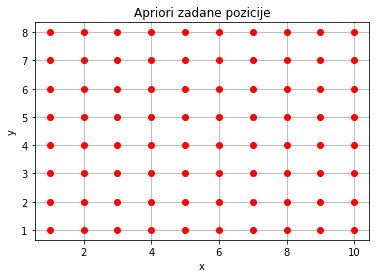

In [35]:
plt.plot(pozicije[:, 0], pozicije[:, 1], 'ro')
plt.title("Apriori zadane pozicije")
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

Dakle, ovdje je M = 80

In [36]:
M = np.shape(pozicije)[0]

D_positions = position_distance(pozicije)
D_positions[0, :]

array([ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
        5.        ,  6.        ,  7.        ,  1.        ,  1.41421356,
        2.23606798,  3.16227766,  4.12310563,  5.09901951,  6.08276253,
        7.07106781,  2.        ,  2.23606798,  2.82842712,  3.60555128,
        4.47213595,  5.38516481,  6.32455532,  7.28010989,  3.        ,
        3.16227766,  3.60555128,  4.24264069,  5.        ,  5.83095189,
        6.70820393,  7.61577311,  4.        ,  4.12310563,  4.47213595,
        5.        ,  5.65685425,  6.40312424,  7.21110255,  8.06225775,
        5.        ,  5.09901951,  5.38516481,  5.83095189,  6.40312424,
        7.07106781,  7.81024968,  8.60232527,  6.        ,  6.08276253,
        6.32455532,  6.70820393,  7.21110255,  7.81024968,  8.48528137,
        9.21954446,  7.        ,  7.07106781,  7.28010989,  7.61577311,
        8.06225775,  8.60232527,  9.21954446,  9.89949494,  8.        ,
        8.06225775,  8.24621125,  8.54400375,  8.94427191,  9.43

In [37]:
senzori = get_sensor(M)
print(senzori)

[[ 1. 10.]
 [ 2. 60.]
 [ 3. 59.]
 [ 4. 69.]
 [ 5.  3.]
 [ 6. 55.]
 [ 7. 49.]
 [ 8.  4.]
 [ 9. 77.]
 [10. 36.]
 [11. 26.]
 [12. 41.]
 [13. 25.]
 [14. 45.]
 [15. 53.]
 [16.  8.]
 [17. 51.]
 [18. 35.]
 [19. 46.]
 [20.  6.]
 [21. 58.]
 [22. 34.]
 [23. 11.]
 [24. 39.]
 [25.  7.]
 [26. 78.]
 [27. 66.]
 [28. 19.]
 [29. 61.]
 [30. 15.]
 [31. 67.]
 [32. 72.]
 [33. 18.]
 [34. 24.]
 [35.  1.]
 [36. 74.]
 [37. 57.]
 [38. 13.]
 [39. 65.]
 [40. 44.]
 [41.  5.]
 [42. 73.]
 [43. 16.]
 [44. 30.]
 [45. 47.]
 [46. 56.]
 [47. 70.]
 [48. 38.]
 [49. 76.]
 [50. 29.]
 [51. 43.]
 [52. 23.]
 [53. 27.]
 [54. 28.]
 [55. 64.]
 [56. 31.]
 [57. 21.]
 [58. 52.]
 [59. 14.]
 [60. 37.]
 [61. 62.]
 [62. 12.]
 [63. 32.]
 [64.  9.]
 [65. 79.]
 [66. 63.]
 [67. 50.]
 [68. 75.]
 [69. 42.]
 [70. 80.]
 [71. 68.]
 [72. 20.]
 [73.  2.]
 [74. 71.]
 [75. 54.]
 [76. 17.]
 [77. 33.]
 [78. 22.]
 [79. 48.]
 [80. 40.]]


Sada mozemo izracunati cisti, noiseless RSSI pomocu inverse square law propagation modela

In [38]:
RSSI_noiseless = get_RSSI_noiseless_square(D_positions, senzori)
RSSI_noiseless[0, :]

array([1.00000000e+01, 2.49376559e-02, 2.69541779e-02, 1.72117040e-02,
       4.76190476e-01, 1.99600798e-02, 3.83141762e-02, 1.96078431e-01,
       1.36798906e-02, 7.63358779e-02, 2.43902439e-01, 5.84795322e-02,
       1.96078431e-01, 3.98406375e-02, 2.93255132e-02, 2.69541779e-02,
       3.83141762e-02, 9.90099010e-02, 3.11526480e-02, 5.84795322e-02,
       2.77008310e-02, 1.09890110e-01, 9.09090909e-01, 2.93255132e-02,
       3.83141762e-02, 1.24843945e-02, 2.03665988e-02, 4.76190476e-01,
       2.21729490e-02, 3.98406375e-02, 1.99600798e-02, 1.17508813e-02,
       9.09090909e-01, 2.69541779e-02, 4.76190476e-01, 1.56006240e-02,
       2.69541779e-02, 1.09890110e-01, 1.99600798e-02, 4.97512438e-02,
       9.90099010e-02, 1.53609831e-02, 2.77008310e-02, 4.97512438e-02,
       2.43309002e-02, 1.63666121e-02, 1.53609831e-02, 3.98406375e-02,
       1.46842878e-02, 7.63358779e-02, 5.84795322e-02, 3.83141762e-02,
       1.96078431e-01, 1.23456790e-01, 1.38696255e-02, 3.43642612e-02,
      

Sada kada imamo noiseless RSSI, mozemo dodati sum, to cemo pospremiti u matricu 'RSSI'

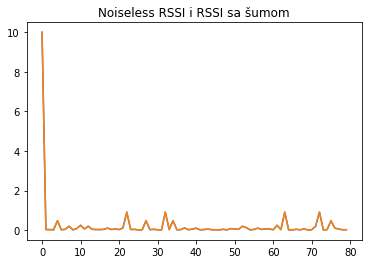

In [40]:
#
stdev = 0.001
noise = np.random.normal(0, stdev, [M ,M])

RSSI = RSSI_noiseless # + noise

# mogu plotat da vidim
plt.plot(RSSI_noiseless[0, :])
plt.plot(RSSI[0, :])
plt.title("Noiseless RSSI i RSSI sa šumom")
plt.show()

Sada cemo izracunati matricu slicnosti C'

In [41]:
C_positions = get_C(D_positions)
C_positions

array([[0.        , 0.96364044, 0.86230336, ..., 0.01972387, 0.01312373,
        0.00810872],
       [0.96364044, 0.        , 0.96364044, ..., 0.02752687, 0.01972387,
        0.01312373],
       [0.86230336, 0.96364044, 0.        , ..., 0.03567399, 0.02752687,
        0.01972387],
       ...,
       [0.01972387, 0.02752687, 0.03567399, ..., 0.        , 0.96364044,
        0.86230336],
       [0.01312373, 0.01972387, 0.02752687, ..., 0.96364044, 0.        ,
        0.96364044],
       [0.00810872, 0.01312373, 0.01972387, ..., 0.86230336, 0.96364044,
        0.        ]])

Sada imamo matricu slicnosti C', te sada pomocu nje racunamo L'

In [42]:
L_positions = get_L(C_positions)
L_positions

array([[ 1.00000000e+00, -4.03346831e-02, -3.60930603e-02, ...,
        -8.25573348e-04, -5.49314262e-04, -3.39403350e-04],
       [-3.44846928e-02,  1.00000000e+00, -3.44846928e-02, ...,
        -9.85072520e-04, -7.05835304e-04, -4.69643794e-04],
       [-2.78394111e-02, -3.11110728e-02,  1.00000000e+00, ...,
        -1.15173269e-03, -8.88703375e-04, -6.36783794e-04],
       ...,
       [-6.36783794e-04, -8.88703375e-04, -1.15173269e-03, ...,
         1.00000000e+00, -3.11110728e-02, -2.78394111e-02],
       [-4.69643794e-04, -7.05835304e-04, -9.85072520e-04, ...,
        -3.44846928e-02,  1.00000000e+00, -3.44846928e-02],
       [-3.39403350e-04, -5.49314262e-04, -8.25573348e-04, ...,
        -3.60930603e-02, -4.03346831e-02,  1.00000000e+00]])

Sada treba izracunati i pronaci najmanje pozitivne svojstvene vektore matrice L' i stvoriti matricu P

In [43]:
k = 2
P = get_keigvec(L_positions, k)
P

array([[-0.16786436, -0.16448958],
       [-0.16911277, -0.12192146],
       [-0.16985378, -0.0749596 ],
       [-0.17019949, -0.02529215],
       [-0.17019949,  0.02529215],
       [-0.16985378,  0.0749596 ],
       [-0.16911277,  0.12192146],
       [-0.16786436,  0.16448958],
       [-0.13693481, -0.16683413],
       [-0.13780878, -0.12344818],
       [-0.13832735, -0.07582147],
       [-0.13856929, -0.0255709 ],
       [-0.13856929,  0.0255709 ],
       [-0.13832735,  0.07582147],
       [-0.13780878,  0.12344818],
       [-0.13693481,  0.16683413],
       [-0.10149536, -0.16838325],
       [-0.10207478, -0.12445736],
       [-0.1024186 , -0.07639157],
       [-0.10257903, -0.02575537],
       [-0.10257903,  0.02575537],
       [-0.1024186 ,  0.07639157],
       [-0.10207478,  0.12445736],
       [-0.10149536,  0.16838325],
       [-0.06246491, -0.16932902],
       [-0.06279653, -0.12507416],
       [-0.06299333, -0.07674037],
       [-0.06308518, -0.0258683 ],
       [-0.06308518,

Sada pomocu matrice RSSI i propagation modela racunamo matricu node_distance D

In [44]:
D = np.zeros([M,M])

for i in range(0, M):
    for j in range(0, M):
        D[i, j] = np.sqrt((1 - RSSI[i, j]/10) / RSSI[i, j])

Sada nalazimo C, L i N od nodeova

In [45]:
C = get_C(D)
L = get_L(C)
N = get_keigvec(L, k)

Sada imamo za izmijeniti 2**k puta predznake u matrici N i sa svakom izracunati sa mađarskim algoritmom parove i cost

Da bismo koristili mađarski algoritam trebamo kreirati cost matricu dimenzija (M,M) tj. to je matrica ciji je [i,j] element jednak euklidskoj udaljenosti izemđu i-tog nodea i j-te pozicije u difuzijskim koordinatama

In [46]:
cost = get_cost(N, P)

In [47]:
indexes = hungarian_alg(cost)

Lowest cost through this matrix:
[  0.2895021423476511,   0.2473584404246924,  0.20097893210967152,  0.15222629029870327,   0.1033622973097984,   0.0581207710372333,  0.03134120045357185, 0.050869780797249506,   0.2902836244950282,  0.24689635922656603,   0.1992703286587785,   0.1490210211369194,  0.09788023334960534, 0.047629528490613304,                  0.0, 0.043394751294259404,   0.2940820425738116,  0.25046770880823105,  0.20294923219557234,    0.153306342588984,  0.10385094892242958,  0.05887944687897591,  0.03574824327495586,  0.05777391039344282,   0.3023163723592339,   0.2595962036432897,  0.21371196980619064,  0.16697013881407008,   0.1229042193455779,  0.08819847013876027,  0.07502986843047851,     0.08821422877631,  0.31560127977173463,   0.2747843269424208,  0.23178484120538892,  0.18943804079972537,  0.15194289262244073,  0.12549270524681713,  0.11662294910173125,    0.125574332651226,   0.3335141435131023,   0.2952854607407667,  0.25582541037485473,   0.2182331331845613

Usporedba pridruzenih pozicija mađarskim algoritmom i pravih pozicija

In [48]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(senzori)

[[ 1. 15.]
 [ 2. 61.]
 [ 3. 62.]
 [ 4. 68.]
 [ 5.  6.]
 [ 6. 50.]
 [ 7. 56.]
 [ 8.  5.]
 [ 9. 76.]
 [10. 37.]
 [11. 31.]
 [12. 48.]
 [13. 32.]
 [14. 44.]
 [15. 52.]
 [16.  1.]
 [17. 54.]
 [18. 38.]
 [19. 43.]
 [20.  3.]
 [21. 63.]
 [22. 39.]
 [23. 14.]
 [24. 34.]
 [25.  2.]
 [26. 75.]
 [27. 71.]
 [28. 22.]
 [29. 60.]
 [30. 10.]
 [31. 70.]
 [32. 65.]
 [33. 23.]
 [34. 17.]
 [35.  8.]
 [36. 79.]
 [37. 64.]
 [38. 12.]
 [39. 72.]
 [40. 45.]
 [41.  4.]
 [42. 80.]
 [43.  9.]
 [44. 27.]
 [45. 42.]
 [46. 49.]
 [47. 67.]
 [48. 35.]
 [49. 77.]
 [50. 28.]
 [51. 46.]
 [52. 18.]
 [53. 30.]
 [54. 29.]
 [55. 57.]
 [56. 26.]
 [57. 20.]
 [58. 53.]
 [59. 11.]
 [60. 36.]
 [61. 59.]
 [62. 13.]
 [63. 25.]
 [64. 16.]
 [65. 74.]
 [66. 58.]
 [67. 55.]
 [68. 78.]
 [69. 47.]
 [70. 73.]
 [71. 69.]
 [72. 21.]
 [73.  7.]
 [74. 66.]
 [75. 51.]
 [76. 24.]
 [77. 40.]
 [78. 19.]
 [79. 41.]
 [80. 33.]]
[[ 1. 10.]
 [ 2. 60.]
 [ 3. 59.]
 [ 4. 69.]
 [ 5.  3.]
 [ 6. 55.]
 [ 7. 49.]
 [ 8.  4.]
 [ 9. 77.]
 [10. 36.]
 [11. 26.

Mogu probat sad preostala 3 slucaja, da izvrtim predznake

2.slucaj: 1.koordinata u -

In [49]:
N[:,0] = -N[:,0]

In [50]:
cost = get_cost(N, P)

indexes = hungarian_alg(cost)

Lowest cost through this matrix:
[  0.4199335885050629,   0.3929466785904842,  0.36609001034845723,  0.34204206567183676,   0.3232703137253887,  0.31146009142577386,  0.30692534110403297,  0.30841605491481694,  0.39968469707787985,   0.3700308726670264,  0.34052834929592224,    0.313992872416967,  0.29319754308066825,   0.2802132487493506,  0.27561755119619397,   0.2781481239702251,   0.3774017132606098,  0.34496561396542674,   0.3124821846005023,  0.28292754783893154,  0.25948060089384123,    0.244792798318708,  0.23988567810551653,   0.2434864064579521,  0.35472248193079464,  0.31938353001680253,   0.2835435445568565,   0.2503074023151078,  0.22333879092332612,  0.20616281370858638,  0.20061189261028314,  0.20546191946269313,  0.33351414351310366,   0.2952854607407681,    0.255825410374856,  0.21823313318456253,   0.1866161079220844,  0.16574331676125062,  0.15902197725117428,  0.16551866707571872,  0.31560127977173585,  0.27478432694242194,   0.2317848412053903,  0.18943804079972645

In [51]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(senzori)

[[ 1. 71.]
 [ 2. 21.]
 [ 3. 22.]
 [ 4. 12.]
 [ 5. 78.]
 [ 6. 26.]
 [ 7. 32.]
 [ 8. 77.]
 [ 9.  4.]
 [10. 45.]
 [11. 55.]
 [12. 40.]
 [13. 56.]
 [14. 36.]
 [15. 28.]
 [16. 73.]
 [17. 30.]
 [18. 46.]
 [19. 35.]
 [20. 75.]
 [21. 23.]
 [22. 47.]
 [23. 70.]
 [24. 42.]
 [25. 74.]
 [26.  3.]
 [27. 15.]
 [28. 62.]
 [29. 20.]
 [30. 66.]
 [31. 14.]
 [32.  9.]
 [33. 63.]
 [34. 57.]
 [35. 80.]
 [36.  7.]
 [37. 24.]
 [38. 68.]
 [39. 16.]
 [40. 37.]
 [41. 76.]
 [42.  8.]
 [43. 65.]
 [44. 51.]
 [45. 34.]
 [46. 25.]
 [47. 11.]
 [48. 43.]
 [49.  5.]
 [50. 52.]
 [51. 38.]
 [52. 58.]
 [53. 54.]
 [54. 53.]
 [55. 17.]
 [56. 50.]
 [57. 60.]
 [58. 29.]
 [59. 67.]
 [60. 44.]
 [61. 19.]
 [62. 69.]
 [63. 49.]
 [64. 72.]
 [65.  2.]
 [66. 18.]
 [67. 31.]
 [68.  6.]
 [69. 39.]
 [70.  1.]
 [71. 13.]
 [72. 61.]
 [73. 79.]
 [74. 10.]
 [75. 27.]
 [76. 64.]
 [77. 48.]
 [78. 59.]
 [79. 33.]
 [80. 41.]]
[[ 1. 10.]
 [ 2. 60.]
 [ 3. 59.]
 [ 4. 69.]
 [ 5.  3.]
 [ 6. 55.]
 [ 7. 49.]
 [ 8.  4.]
 [ 9. 77.]
 [10. 36.]
 [11. 26.

3. slucaj: 2. koordinata u -

In [52]:
N[:,0] = -N[:,0] # da vratimo zbog 1. slucaja
N[:,1] = -N[:,1]

In [53]:
cost = get_cost(N, P)

indexes = hungarian_alg(cost)

Lowest cost through this matrix:
[ 0.05086978079724898,  0.03134120045357364, 0.058120771037234356,  0.10336229730980066,  0.15222629029870577,  0.20097893210967221,  0.24735844042469302,  0.28950214234765353, 0.043394751294259765,                  0.0, 0.047629528490614484,  0.09788023334960652,  0.14902102113692053,  0.19927032865877967,  0.24689635922656752,   0.2902836244950295, 0.057773910393443116,  0.03574824327495607,  0.05887944687897674,  0.10385094892243042,  0.15330634258898482,  0.20294923219557345,  0.25046770880823194,  0.29408204257381276,  0.08821422877631034,  0.07502986843047908,    0.088198470138761,  0.12290421934557877,  0.16697013881407102,   0.2137119698061917,  0.25959620364329056,   0.3023163723592348,  0.12557433265122653,  0.11662294910173177,  0.12549270524681777,  0.15194289262244154,  0.18943804079972618,  0.23178484120539009,   0.2747843269424218,  0.31560127977173585,  0.16551866707571813,  0.15902197725117384,   0.1657433167612503,  0.18661610792208408

In [54]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(senzori)

[[ 1. 10.]
 [ 2. 60.]
 [ 3. 59.]
 [ 4. 69.]
 [ 5.  3.]
 [ 6. 55.]
 [ 7. 49.]
 [ 8.  4.]
 [ 9. 77.]
 [10. 36.]
 [11. 26.]
 [12. 41.]
 [13. 25.]
 [14. 45.]
 [15. 53.]
 [16.  8.]
 [17. 51.]
 [18. 35.]
 [19. 46.]
 [20.  6.]
 [21. 58.]
 [22. 34.]
 [23. 11.]
 [24. 39.]
 [25.  7.]
 [26. 78.]
 [27. 66.]
 [28. 19.]
 [29. 61.]
 [30. 15.]
 [31. 67.]
 [32. 72.]
 [33. 18.]
 [34. 24.]
 [35.  1.]
 [36. 74.]
 [37. 57.]
 [38. 13.]
 [39. 65.]
 [40. 44.]
 [41.  5.]
 [42. 73.]
 [43. 16.]
 [44. 30.]
 [45. 47.]
 [46. 56.]
 [47. 70.]
 [48. 38.]
 [49. 76.]
 [50. 29.]
 [51. 43.]
 [52. 23.]
 [53. 27.]
 [54. 28.]
 [55. 64.]
 [56. 31.]
 [57. 21.]
 [58. 52.]
 [59. 14.]
 [60. 37.]
 [61. 62.]
 [62. 12.]
 [63. 32.]
 [64.  9.]
 [65. 79.]
 [66. 63.]
 [67. 50.]
 [68. 75.]
 [69. 42.]
 [70. 80.]
 [71. 68.]
 [72. 20.]
 [73.  2.]
 [74. 71.]
 [75. 54.]
 [76. 17.]
 [77. 33.]
 [78. 22.]
 [79. 48.]
 [80. 40.]]
[[ 1. 10.]
 [ 2. 60.]
 [ 3. 59.]
 [ 4. 69.]
 [ 5.  3.]
 [ 6. 55.]
 [ 7. 49.]
 [ 8.  4.]
 [ 9. 77.]
 [10. 36.]
 [11. 26.

Zadnji slucaj: obje koordinate u -

In [55]:
N[:,0] = -N[:,0]

In [56]:
cost = get_cost(N, P)

indexes = hungarian_alg(cost)

Lowest cost through this matrix:
[  0.3084160549148166,  0.30692534110403386,   0.3114600914257742,   0.3232703137253887,   0.3420420656718377,  0.36609001034845673,  0.39294667859048327,   0.4199335885050639,  0.27814812397022537,   0.2756175511961943,  0.28021324874935105,   0.2931975430806687,  0.31399287241696666,   0.3405283492959219,   0.3700308726670264,  0.39968469707787974,  0.24348640645795236,  0.23988567810551698,   0.2447927983187082,   0.2594806008938411,   0.2829275478389315,  0.31248218460050214,   0.3449656139654262,   0.3774017132606096,  0.20546191946269363,  0.20061189261028323,  0.20616281370858647,  0.22333879092332604,  0.25030740231510773,  0.28354354455685643,  0.31938353001680225,   0.3547224819307941,   0.1655186670757186,  0.15902197725117442,  0.16574331676125081,  0.18661610792208427,  0.21823313318456242,  0.25582541037485595,  0.29528546074076795,  0.33351414351310377,  0.12557433265122694,  0.11662294910173229,  0.12549270524681824,  0.15194289262244182

In [57]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(senzori)

[[ 1. 66.]
 [ 2. 20.]
 [ 3. 19.]
 [ 4. 13.]
 [ 5. 75.]
 [ 6. 31.]
 [ 7. 25.]
 [ 8. 76.]
 [ 9.  5.]
 [10. 44.]
 [11. 50.]
 [12. 33.]
 [13. 49.]
 [14. 37.]
 [15. 29.]
 [16. 80.]
 [17. 27.]
 [18. 43.]
 [19. 38.]
 [20. 78.]
 [21. 18.]
 [22. 42.]
 [23. 67.]
 [24. 47.]
 [25. 79.]
 [26.  6.]
 [27. 10.]
 [28. 59.]
 [29. 21.]
 [30. 71.]
 [31. 11.]
 [32. 16.]
 [33. 58.]
 [34. 64.]
 [35. 73.]
 [36.  2.]
 [37. 17.]
 [38. 69.]
 [39.  9.]
 [40. 36.]
 [41. 77.]
 [42.  1.]
 [43. 72.]
 [44. 54.]
 [45. 39.]
 [46. 32.]
 [47. 14.]
 [48. 46.]
 [49.  4.]
 [50. 53.]
 [51. 35.]
 [52. 63.]
 [53. 51.]
 [54. 52.]
 [55. 24.]
 [56. 55.]
 [57. 61.]
 [58. 28.]
 [59. 70.]
 [60. 45.]
 [61. 22.]
 [62. 68.]
 [63. 56.]
 [64. 65.]
 [65.  7.]
 [66. 23.]
 [67. 26.]
 [68.  3.]
 [69. 34.]
 [70.  8.]
 [71. 12.]
 [72. 60.]
 [73. 74.]
 [74. 15.]
 [75. 30.]
 [76. 57.]
 [77. 41.]
 [78. 62.]
 [79. 40.]
 [80. 48.]]
[[ 1. 10.]
 [ 2. 60.]
 [ 3. 59.]
 [ 4. 69.]
 [ 5.  3.]
 [ 6. 55.]
 [ 7. 49.]
 [ 8.  4.]
 [ 9. 77.]
 [10. 36.]
 [11. 26.

BINGO!, jedan od ovih 4 je uvijek

## Drukcije / dodajemo noise

In [34]:
# drukciji path loss model

def get_RSSI_noiseless(D_positions, senzori, a, eta, T):
    M = np.shape(senzori)[0]
    RSSI_noiseless = np.zeros([M, M])

    for i in range(0, M):
        for j in range(0, M):
            if(D_positions[int(senzori[i, 1]) - 1, int(senzori[j, 1]) - 1] == 0):
                RSSI_noiseless[i, j] = a + 10*eta*np.log10(T)
            else:
                RSSI_noiseless[i, j] = a - 10*eta*np.log10(D_positions[int(senzori[i, 1]) - 1, int(senzori[j, 1]) - 1]) + 10*eta*np.log10(T)
    return RSSI_noiseless

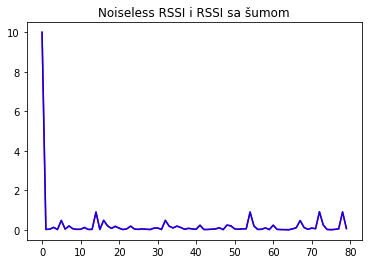

In [535]:
#a = -50
#eta = 3
#T = 1
#RSSI_noiseless = get_RSSI_noiseless(D_positions, senzori, a, eta, T)


RSSI_noiseless = get_RSSI_noiseless_square(D_positions, senzori)
stdev = 0.01
noise = np.zeros([M, M])
for i in range(0, M):
    for j in range(0, M):
        if (i != j):
            while 1:
                x = np.random.normal(0, stdev)
                if(RSSI_noiseless[i, j] + x > 0 and RSSI_noiseless[i, j] + x <= 10):
                    noise[i, j] = x
                    break

#noise = np.random.normal(0, 10 ,[M, M])
RSSI = RSSI_noiseless + noise

# mogu plotat da vidim
plt.plot(RSSI_noiseless[0, :], color='red')
plt.plot(RSSI[0, :], color='blue')
plt.title("Noiseless RSSI i RSSI sa šumom")
plt.show()

In [536]:
C_positions = get_C(D_positions)
L_positions = get_L(C_positions)
k = 2
P = get_keigvec(L_positions, k)
print(P)

In [537]:
D = np.zeros([M,M])

#for i in range(0, M):
#    for j in range(0, M):
#        D[i, j] = np.power(10, (a + 10*eta*np.log10(T) - RSSI[i, j]) / (10*eta))

for i in range(0, M):
    for j in range(0, M):
        D[i, j] = np.sqrt((1 - RSSI[i, j]/10) / RSSI[i, j])

In [538]:
C = get_C(D)
L = get_L(C)
N = get_keigvec(L, k)
N = N.real

In [539]:
cost = get_cost(N, P)
indexes = hungarian_alg(cost)

In [540]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(get_accuracy(senzori[:, 1], (indexes+np.ones([M,2]))[:, 1]))

[[ 1. 59.]
 [ 2. 16.]
 [ 3. 19.]
 [ 4. 45.]
 [ 5. 23.]
 [ 6. 66.]
 [ 7. 20.]
 [ 8. 74.]
 [ 9. 28.]
 [10. 31.]
 [11. 17.]
 [12. 62.]
 [13. 14.]
 [14. 40.]
 [15. 58.]
 [16.  2.]
 [17. 68.]
 [18. 42.]
 [19. 46.]
 [20. 76.]
 [21. 37.]
 [22.  7.]
 [23. 38.]
 [24. 44.]
 [25. 21.]
 [26. 48.]
 [27. 63.]
 [28. 64.]
 [29.  8.]
 [30. 79.]
 [31. 33.]
 [32. 13.]
 [33. 50.]
 [34. 65.]
 [35. 54.]
 [36. 69.]
 [37. 77.]
 [38. 80.]
 [39. 34.]
 [40. 25.]
 [41. 56.]
 [42. 61.]
 [43.  6.]
 [44. 32.]
 [45. 18.]
 [46. 39.]
 [47. 35.]
 [48. 24.]
 [49. 57.]
 [50. 53.]
 [51. 29.]
 [52. 30.]
 [53. 26.]
 [54. 71.]
 [55. 67.]
 [56. 49.]
 [57. 22.]
 [58. 72.]
 [59. 70.]
 [60.  3.]
 [61. 75.]
 [62. 12.]
 [63.  4.]
 [64.  5.]
 [65. 15.]
 [66. 47.]
 [67. 73.]
 [68. 52.]
 [69. 41.]
 [70. 11.]
 [71. 36.]
 [72. 55.]
 [73. 60.]
 [74. 43.]
 [75.  1.]
 [76.  9.]
 [77. 10.]
 [78. 78.]
 [79. 51.]
 [80. 27.]]
0.0


In [541]:
N[:,0] = -N[:,0]

In [542]:
cost = get_cost(N, P)
indexes = hungarian_alg(cost)

In [543]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(get_accuracy(senzori[:, 1], (indexes+np.ones([M,2]))[:, 1]))

[[ 1. 19.]
 [ 2. 72.]
 [ 3. 59.]
 [ 4. 37.]
 [ 5. 63.]
 [ 6. 10.]
 [ 7. 60.]
 [ 8.  2.]
 [ 9. 52.]
 [10. 55.]
 [11. 57.]
 [12. 22.]
 [13. 70.]
 [14. 48.]
 [15. 18.]
 [16. 74.]
 [17. 12.]
 [18. 34.]
 [19. 38.]
 [20.  4.]
 [21. 45.]
 [22. 79.]
 [23. 46.]
 [24. 36.]
 [25. 61.]
 [26. 40.]
 [27. 23.]
 [28. 24.]
 [29. 80.]
 [30.  7.]
 [31. 41.]
 [32. 69.]
 [33. 26.]
 [34.  9.]
 [35. 30.]
 [36. 13.]
 [37.  5.]
 [38.  8.]
 [39. 42.]
 [40. 49.]
 [41. 32.]
 [42. 21.]
 [43. 78.]
 [44. 56.]
 [45. 58.]
 [46. 47.]
 [47. 43.]
 [48. 64.]
 [49. 17.]
 [50. 29.]
 [51. 53.]
 [52. 54.]
 [53. 50.]
 [54. 15.]
 [55. 11.]
 [56. 25.]
 [57. 62.]
 [58. 16.]
 [59. 14.]
 [60. 75.]
 [61.  3.]
 [62. 68.]
 [63. 76.]
 [64. 77.]
 [65. 71.]
 [66. 39.]
 [67.  1.]
 [68. 28.]
 [69. 33.]
 [70. 67.]
 [71. 44.]
 [72. 31.]
 [73. 20.]
 [74. 35.]
 [75. 73.]
 [76. 65.]
 [77. 66.]
 [78.  6.]
 [79. 27.]
 [80. 51.]]
0.95


In [544]:
N[:,0] = -N[:,0] # da vratimo zbog 1. slucaja
N[:,1] = -N[:,1]

cost = get_cost(N, P)
indexes = hungarian_alg(cost)

In [545]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(get_accuracy(senzori[:, 1], (indexes+np.ones([M,2]))[:, 1]))

[[ 1. 62.]
 [ 2.  9.]
 [ 3. 22.]
 [ 4. 44.]
 [ 5. 18.]
 [ 6. 71.]
 [ 7. 21.]
 [ 8. 79.]
 [ 9. 29.]
 [10. 26.]
 [11. 24.]
 [12. 59.]
 [13. 11.]
 [14. 33.]
 [15. 63.]
 [16.  7.]
 [17. 69.]
 [18. 47.]
 [19. 43.]
 [20. 77.]
 [21. 36.]
 [22.  2.]
 [23. 35.]
 [24. 45.]
 [25. 20.]
 [26. 41.]
 [27. 58.]
 [28. 57.]
 [29.  1.]
 [30. 74.]
 [31. 40.]
 [32. 12.]
 [33. 55.]
 [34. 72.]
 [35. 51.]
 [36. 68.]
 [37. 76.]
 [38. 73.]
 [39. 39.]
 [40. 32.]
 [41. 49.]
 [42. 60.]
 [43.  3.]
 [44. 25.]
 [45. 23.]
 [46. 34.]
 [47. 38.]
 [48. 17.]
 [49. 64.]
 [50. 52.]
 [51. 28.]
 [52. 27.]
 [53. 31.]
 [54. 66.]
 [55. 70.]
 [56. 56.]
 [57. 19.]
 [58. 65.]
 [59. 67.]
 [60.  6.]
 [61. 78.]
 [62. 13.]
 [63.  5.]
 [64.  4.]
 [65. 10.]
 [66. 42.]
 [67. 80.]
 [68. 53.]
 [69. 48.]
 [70. 14.]
 [71. 37.]
 [72. 50.]
 [73. 61.]
 [74. 46.]
 [75.  8.]
 [76. 16.]
 [77. 15.]
 [78. 75.]
 [79. 54.]
 [80. 30.]]
0.0


In [546]:
N[:,0] = -N[:,0]

cost = get_cost(N, P)
indexes = hungarian_alg(cost)

In [547]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(get_accuracy(senzori[:, 1], (indexes+np.ones([M,2]))[:, 1]))

[[ 1. 22.]
 [ 2. 65.]
 [ 3. 62.]
 [ 4. 36.]
 [ 5. 58.]
 [ 6. 15.]
 [ 7. 61.]
 [ 8.  7.]
 [ 9. 53.]
 [10. 50.]
 [11. 64.]
 [12. 19.]
 [13. 67.]
 [14. 41.]
 [15. 23.]
 [16. 79.]
 [17. 13.]
 [18. 39.]
 [19. 35.]
 [20.  5.]
 [21. 44.]
 [22. 74.]
 [23. 43.]
 [24. 37.]
 [25. 60.]
 [26. 33.]
 [27. 18.]
 [28. 17.]
 [29. 73.]
 [30.  2.]
 [31. 48.]
 [32. 68.]
 [33. 31.]
 [34. 16.]
 [35. 27.]
 [36. 12.]
 [37.  4.]
 [38.  1.]
 [39. 47.]
 [40. 56.]
 [41. 25.]
 [42. 20.]
 [43. 75.]
 [44. 49.]
 [45. 63.]
 [46. 42.]
 [47. 46.]
 [48. 57.]
 [49. 24.]
 [50. 28.]
 [51. 52.]
 [52. 51.]
 [53. 55.]
 [54. 10.]
 [55. 14.]
 [56. 32.]
 [57. 59.]
 [58.  9.]
 [59. 11.]
 [60. 78.]
 [61.  6.]
 [62. 69.]
 [63. 77.]
 [64. 76.]
 [65. 66.]
 [66. 34.]
 [67.  8.]
 [68. 29.]
 [69. 40.]
 [70. 70.]
 [71. 45.]
 [72. 26.]
 [73. 21.]
 [74. 38.]
 [75. 80.]
 [76. 72.]
 [77. 71.]
 [78.  3.]
 [79. 30.]
 [80. 54.]]
0.0


### Ovo izvrtit prije visestrukog koristenja fje hungarian_alg da ne ispisuje

In [65]:
# ovaj runat prije visestrukog koristenja ove fje
def hungarian_alg(cost):
    m = Munkres()
    indexes = m.compute(cost)
    #print_matrix(cost, msg='Lowest cost through this matrix:')
    total = 0
    for row, column in indexes:
        value = cost[row][column]
        total += value
        #print(f'({row+1}, {column+1}) -> {value}')
    #print(f'total cost: {total}')
    
    return np.asarray(indexes)

# SNR

### Primjer 1

In [27]:
# dovoljno jednom provrtit
x = 10
y = 8
pozicije = []
for i in range(0, x):
    for j in range(0, y):
        pozicije.append([i+1, j+1])
pozicije = np.asarray(pozicije)

M = np.shape(pozicije)[0]
D_positions = position_distance(pozicije)
C_positions = get_C(D_positions)
L_positions = get_L(C_positions)
k = 2
P = get_keigvec(L_positions, k)

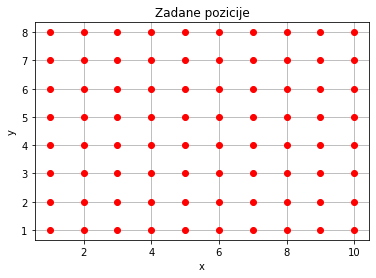

In [29]:
plt.plot(pozicije[:, 0], pozicije[:, 1], 'ro')
plt.title("Zadane pozicije")
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

In [29]:
SNR_values = [1, 5, 10, 30, 100, 300, 1000]

In [30]:
sredina = np.zeros([len(SNR_values), 1])
donja = np.zeros([len(SNR_values), 1])
gornja = np.zeros([len(SNR_values), 1])
    
B = 10
    
for snr in range(0, len(SNR_values)):
    sredine = np.zeros([B, 1])
    for i in range(0, B):
        senzori = get_sensor(M)
        RSSI_noiseless = get_RSSI_noiseless_square(D_positions, senzori)
        stdev = np.mean(RSSI_noiseless) / SNR_values[snr]
        noise = np.zeros([M, M])
        for j in range(0, M):
            for k in range(0, M):
                if (j != k):
                    while 1:
                        x = np.random.normal(0, stdev)
                        if(RSSI_noiseless[j, k] + x > 0 and RSSI_noiseless[j, k] + x <= 10):
                            noise[j, k] = x
                            break

        RSSI = RSSI_noiseless + noise
        
        D = np.zeros([M,M])
        for j in range(0, M):
            for k in range(0, M):
                D[j, k] = np.sqrt((1 - RSSI[j, k]/10) / RSSI[j, k])
        C = get_C(D)
        L = get_L(C)
        N = get_keigvec(L, 2)
        N = N.real
        
        sredine[i] = get_best_accuracy(N, P, senzori)
        print(f'SNR: {SNR_values[snr]} : {i+1}/{B}')
    
    sredina[snr], donja[snr], gornja[snr] = mean_confidence_interval(sredine, 0.99)

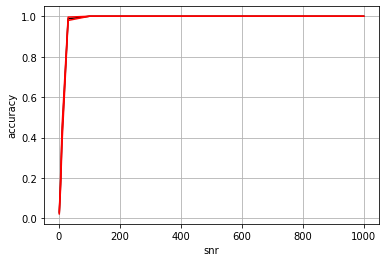

In [39]:
plt.plot(SNR_values, sredina, color="black")
plt.plot(SNR_values, donja, color="red")
plt.plot(SNR_values, gornja, color="red")
plt.ylabel('accuracy')
plt.xlabel('snr')
plt.grid()
plt.show()

### Primjer 2

In [32]:
x = 10
y = 8
pozicije = []
for i in range(0, x):
    for j in range(0, y):
        pozicije.append([random.uniform(1, x), random.uniform(1, y)])
pozicije = np.asarray(pozicije)

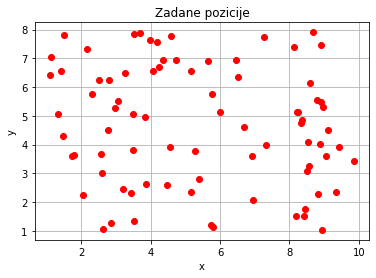

In [33]:
plt.plot(pozicije[:, 0], pozicije[:, 1], 'ro')
plt.title("Zadane pozicije")
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

In [18]:
M = np.shape(pozicije)[0]
D_positions = position_distance(pozicije)
C_positions = get_C(D_positions)
L_positions = get_L(C_positions)
k = 2
P = get_keigvec(L_positions, k)

In [25]:
SNR_values = [1, 10, 100, 500, 1000]

sredina = np.zeros([len(SNR_values), 1])
donja = np.zeros([len(SNR_values), 1])
gornja = np.zeros([len(SNR_values), 1])
    
B = 10
    
for snr in range(0, len(SNR_values)):
    sredine = np.zeros([B, 1])
    for i in range(0, B):
        senzori = get_sensor(M)
        RSSI_noiseless = get_RSSI_noiseless_square(D_positions, senzori)
        stdev = np.mean(RSSI_noiseless) / SNR_values[snr]
        noise = np.zeros([M, M])
        for j in range(0, M):
            for k in range(0, M):
                if (j != k):
                    while 1:
                        x = np.random.normal(0, stdev)
                        if(RSSI_noiseless[j, k] + x > 0 and RSSI_noiseless[j, k] + x <= 10):
                            noise[j, k] = x
                            break

        RSSI = RSSI_noiseless + noise
        
        D = np.zeros([M,M])
        for j in range(0, M):
            for k in range(0, M):
                D[j, k] = np.sqrt((1 - RSSI[j, k]/10) / RSSI[j, k])
        C = get_C(D)
        L = get_L(C)
        N = get_keigvec(L, 2)
        N = N.real
        
        sredine[i] = get_best_accuracy(N, P, senzori)
        print(f'SNR: {SNR_values[snr]} : {i+1}/{B}')
    
    sredina[snr], donja[snr], gornja[snr] = mean_confidence_interval(sredine, 0.99)

SNR: 1 : 1/10
SNR: 1 : 2/10
SNR: 1 : 3/10
SNR: 1 : 4/10
SNR: 1 : 5/10
SNR: 1 : 6/10
SNR: 1 : 7/10
SNR: 1 : 8/10
SNR: 1 : 9/10
SNR: 1 : 10/10
SNR: 10 : 1/10
SNR: 10 : 2/10
SNR: 10 : 3/10
SNR: 10 : 4/10
SNR: 10 : 5/10
SNR: 10 : 6/10
SNR: 10 : 7/10
SNR: 10 : 8/10
SNR: 10 : 9/10
SNR: 10 : 10/10
SNR: 100 : 1/10
SNR: 100 : 2/10
SNR: 100 : 3/10
SNR: 100 : 4/10
SNR: 100 : 5/10
SNR: 100 : 6/10
SNR: 100 : 7/10
SNR: 100 : 8/10
SNR: 100 : 9/10
SNR: 100 : 10/10
SNR: 500 : 1/10
SNR: 500 : 2/10
SNR: 500 : 3/10
SNR: 500 : 4/10
SNR: 500 : 5/10
SNR: 500 : 6/10
SNR: 500 : 7/10
SNR: 500 : 8/10
SNR: 500 : 9/10
SNR: 500 : 10/10
SNR: 1000 : 1/10
SNR: 1000 : 2/10
SNR: 1000 : 3/10
SNR: 1000 : 4/10
SNR: 1000 : 5/10
SNR: 1000 : 6/10
SNR: 1000 : 7/10
SNR: 1000 : 8/10
SNR: 1000 : 9/10
SNR: 1000 : 10/10


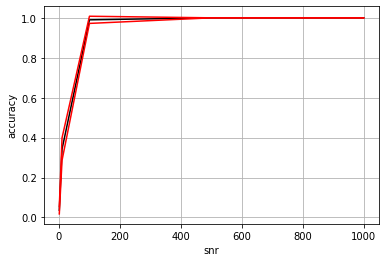

In [26]:
plt.plot(SNR_values, sredina, color="black")
plt.plot(SNR_values, donja, color="red")
plt.plot(SNR_values, gornja, color="red")
plt.ylabel('accuracy')
plt.xlabel('snr')
plt.grid()
plt.show()

### Primjer 3 / pokusaj

In [105]:
# i kad uzmem neki daljnji vektor, dobivam jos losije rezultate

In [104]:
x = 20
y = 2
pozicije = []
for i in range(0, x):
    for j in range(0, y):
        pozicije.append([i + 1, j + 1])
pozicije = np.asarray(pozicije)

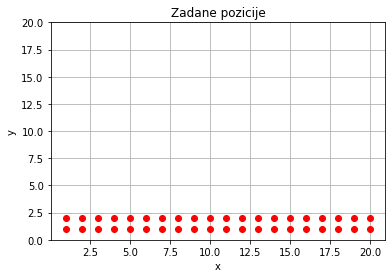

In [77]:
plt.plot(pozicije[:, 0], pozicije[:, 1], 'ro')
plt.title("Zadane pozicije")
plt.ylim([0, 20])
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

In [62]:
M = np.shape(pozicije)[0]
D_positions = position_distance(pozicije)
C_positions = get_C(D_positions)
L_positions = get_L(C_positions)

1. slucaj

In [63]:
k = 2
P = get_keigvec(L_positions, k)

In [68]:
SNR_values = [1, 10, 100, 500, 1000]

sredina1 = np.zeros([len(SNR_values), 1])
donja1 = np.zeros([len(SNR_values), 1])
gornja1 = np.zeros([len(SNR_values), 1])
    
B = 10
    
for snr in range(0, len(SNR_values)):
    sredine = np.zeros([B, 1])
    for i in range(0, B):
        senzori = get_sensor(M)
        RSSI_noiseless = get_RSSI_noiseless_square(D_positions, senzori)
        stdev = np.mean(RSSI_noiseless) / SNR_values[snr]
        noise = np.zeros([M, M])
        for j in range(0, M):
            for k in range(0, M):
                if (j != k):
                    while 1:
                        x = np.random.normal(0, stdev)
                        if(RSSI_noiseless[j, k] + x > 0 and RSSI_noiseless[j, k] + x <= 10):
                            noise[j, k] = x
                            break

        RSSI = RSSI_noiseless + noise
        
        D = np.zeros([M,M])
        for j in range(0, M):
            for k in range(0, M):
                D[j, k] = np.sqrt((1 - RSSI[j, k]/10) / RSSI[j, k])
        C = get_C(D)
        L = get_L(C)
        N = get_keigvec(L, 2)
        N = N.real
        
        sredine[i] = get_best_accuracy(N, P, senzori)
        print(f'SNR: {SNR_values[snr]} : {i+1}/{B}')
    
    sredina1[snr], donja1[snr], gornja1[snr] = mean_confidence_interval(sredine, 0.99)

SNR: 1 : 1/10
SNR: 1 : 2/10
SNR: 1 : 3/10
SNR: 1 : 4/10
SNR: 1 : 5/10
SNR: 1 : 6/10
SNR: 1 : 7/10
SNR: 1 : 8/10
SNR: 1 : 9/10
SNR: 1 : 10/10
SNR: 10 : 1/10
SNR: 10 : 2/10
SNR: 10 : 3/10
SNR: 10 : 4/10
SNR: 10 : 5/10
SNR: 10 : 6/10
SNR: 10 : 7/10
SNR: 10 : 8/10
SNR: 10 : 9/10
SNR: 10 : 10/10
SNR: 100 : 1/10
SNR: 100 : 2/10
SNR: 100 : 3/10
SNR: 100 : 4/10
SNR: 100 : 5/10
SNR: 100 : 6/10
SNR: 100 : 7/10
SNR: 100 : 8/10
SNR: 100 : 9/10
SNR: 100 : 10/10
SNR: 500 : 1/10
SNR: 500 : 2/10
SNR: 500 : 3/10
SNR: 500 : 4/10
SNR: 500 : 5/10
SNR: 500 : 6/10
SNR: 500 : 7/10
SNR: 500 : 8/10
SNR: 500 : 9/10
SNR: 500 : 10/10
SNR: 1000 : 1/10
SNR: 1000 : 2/10
SNR: 1000 : 3/10
SNR: 1000 : 4/10
SNR: 1000 : 5/10
SNR: 1000 : 6/10
SNR: 1000 : 7/10
SNR: 1000 : 8/10
SNR: 1000 : 9/10
SNR: 1000 : 10/10


2. slucaj, uzimamo 1. i 4. najmanji svoj. vektor, dakle preskacemo 2. i 3.

In [100]:
w, v = np.linalg.eig(L)
w = np.asarray(w)
v = np.asarray(v)
    
idx = np.argsort(w)
P = v[:,[idx[1], idx[4]]]

# PRIPAZIT, moramo i u N napravit promjene !

In [101]:
sredina2 = np.zeros([len(SNR_values), 1])
donja2 = np.zeros([len(SNR_values), 1])
gornja2 = np.zeros([len(SNR_values), 1])
    
B = 10
    
for snr in range(0, len(SNR_values)):
    sredine = np.zeros([B, 1])
    for i in range(0, B):
        senzori = get_sensor(M)
        RSSI_noiseless = get_RSSI_noiseless_square(D_positions, senzori)
        stdev = np.mean(RSSI_noiseless) / SNR_values[snr]
        noise = np.zeros([M, M])
        for j in range(0, M):
            for k in range(0, M):
                if (j != k):
                    while 1:
                        x = np.random.normal(0, stdev)
                        if(RSSI_noiseless[j, k] + x > 0 and RSSI_noiseless[j, k] + x <= 10):
                            noise[j, k] = x
                            break

        RSSI = RSSI_noiseless + noise
        
        D = np.zeros([M,M])
        for j in range(0, M):
            for k in range(0, M):
                D[j, k] = np.sqrt((1 - RSSI[j, k]/10) / RSSI[j, k])
        C = get_C(D)
        L = get_L(C)
        
        w, v = np.linalg.eig(L)
        w.real
        v.real
        w = np.asarray(w)
        v = np.asarray(v)
        idx = np.argsort(w)
        N = v[:,[idx[1], idx[4]]]
        
        N = N.real
        
        sredine[i] = get_best_accuracy(N, P, senzori)
        print(f'SNR: {SNR_values[snr]} : {i+1}/{B}')
    
    sredina2[snr], donja2[snr], gornja2[snr] = mean_confidence_interval(sredine, 0.99)

C:\Users\Tin\anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


SNR: 1 : 1/10
SNR: 1 : 2/10
SNR: 1 : 3/10
SNR: 1 : 4/10
SNR: 1 : 5/10
SNR: 1 : 6/10
SNR: 1 : 7/10
SNR: 1 : 8/10
SNR: 1 : 9/10
SNR: 1 : 10/10
SNR: 10 : 1/10
SNR: 10 : 2/10
SNR: 10 : 3/10
SNR: 10 : 4/10
SNR: 10 : 5/10
SNR: 10 : 6/10
SNR: 10 : 7/10
SNR: 10 : 8/10
SNR: 10 : 9/10
SNR: 10 : 10/10
SNR: 100 : 1/10
SNR: 100 : 2/10
SNR: 100 : 3/10
SNR: 100 : 4/10
SNR: 100 : 5/10
SNR: 100 : 6/10
SNR: 100 : 7/10
SNR: 100 : 8/10
SNR: 100 : 9/10
SNR: 100 : 10/10
SNR: 500 : 1/10
SNR: 500 : 2/10
SNR: 500 : 3/10
SNR: 500 : 4/10
SNR: 500 : 5/10
SNR: 500 : 6/10
SNR: 500 : 7/10
SNR: 500 : 8/10
SNR: 500 : 9/10
SNR: 500 : 10/10
SNR: 1000 : 1/10
SNR: 1000 : 2/10
SNR: 1000 : 3/10
SNR: 1000 : 4/10
SNR: 1000 : 5/10
SNR: 1000 : 6/10
SNR: 1000 : 7/10
SNR: 1000 : 8/10
SNR: 1000 : 9/10
SNR: 1000 : 10/10


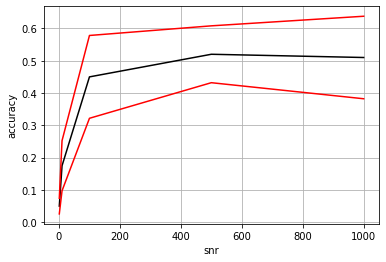

In [67]:
plt.plot(SNR_values, sredina, color="black")
plt.plot(SNR_values, donja, color="red")
plt.plot(SNR_values, gornja, color="red")
plt.ylabel('accuracy')
plt.xlabel('snr')
plt.grid()
plt.show()

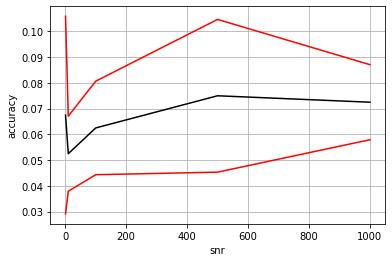

In [102]:
plt.plot(SNR_values, sredina2, color="black")
plt.plot(SNR_values, donja2, color="red")
plt.plot(SNR_values, gornja2, color="red")
plt.ylabel('accuracy')
plt.xlabel('snr')
plt.grid()
plt.show()

## Po predavanju / pokusaj

In [180]:
# Program to multiply two matrices using nested loops
def matrix_mult(A, B):
    dim1 = np.shape(A)[0]
    dim2 = np.shape(B)[1]
    result = np.zeros([dim1, dim2])

    for i in range(dim1):
        for j in range(dim2):
            for k in range(dim2):
                result[i][j] += A[i][k] * B[k][j]
    return result

In [278]:
x = 10
y = 8
pozicije = []
for i in range(0, x):
    for j in range(0, y):
        pozicije.append([i+1, j+1])
pozicije = np.asarray(pozicije)

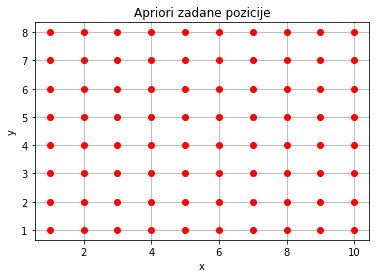

In [279]:
plt.plot(pozicije[:, 0], pozicije[:, 1], 'ro')
plt.title("Apriori zadane pozicije")
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

In [280]:
M = np.shape(pozicije)[0]

# euklidske udaljenosti izmedu pozicija
D_positions = position_distance(pozicije)

# random raspodjela senzora po pozicijama
senzori = get_sensor(M)

In [281]:
# 1. - matrica K
K = np.zeros(np.shape(D_positions))
sigma = 1/(M**2) * np.sum(np.power(D_positions, 2))
for i in range(0, M):
    for j in range(0, M):
        K[i, j] = gaussian_kernel(D_positions[i, j], sigma)
        
# matrica D
sum_row_K = np.sum(K, axis=1)
D = np.zeros([M, M])
for i in range(0, M):
    D[i, i] = sum_row_K[i]

In [282]:
# 2. - matrica P_s
D2 = D
for i in range(0, M):
    D2[i, i] = np.power(D[i, i], -1/2)
P_s = matrix_mult(D2, matrix_mult(K, D2))

# njena spektralna dekompozicija (inv(U) = t(U), tj U je ortogonalna)
w, U = np.linalg.eig(P_s)
lam = np.zeros([len(w), len(w)])
for i in range(0, len(w)):
    lam[i, i] = w[i]

In [283]:
# 3. - matrica V
V = matrix_mult(D2, U)

In [284]:
# 4. - dif. koordinate u trenutku t
t = 1
psi = matrix_mult(np.power(lam, t), np.transpose(V))

In [285]:
# 5. - redukcija na k redaka
k = 2
psi = psi[0:k, :]

In [286]:
# sada sve isto za senzore

In [287]:
RSSI_noiseless = get_RSSI_noiseless_square(D_positions, senzori)

noise = np.random.normal(0, np.min(RSSI_noiseless)/3 ,[M, M])
RSSI = RSSI_noiseless + abs(noise)
# ne diramo rssi na dijagonali
for i in range(0, M):
    RSSI[i, i] = 10

In [288]:
# noisy D
noisyD = np.zeros([M,M])
for i in range(0, M):
    for j in range(0, M):
        noisyD[i, j] = np.sqrt((1-RSSI[i, j]/10) / RSSI[i, j])

In [289]:
# 1. - matrica K
K2 = np.zeros(np.shape(noisyD))
sigma2 = 1/(M**2) * np.sum(np.power(noisyD, 2))
for i in range(0, M):
    for j in range(0, M):
        K2[i, j] = gaussian_kernel(noisyD[i, j], sigma2)
        
# matrica D
sum_row_K2 = np.sum(K2, axis=1)
DD = np.zeros([M, M])
for i in range(0, M):
    DD[i, i] = sum_row_K2[i]

In [290]:
# 2. - matrica P_s
DD2 = DD
for i in range(0, M):
    DD2[i, i] = np.power(DD[i, i], -1/2)
P_s2 = matrix_mult(DD2, matrix_mult(K2, DD2))

# njena spektralna dekompozicija (inv(U) = t(U), tj U je ortogonalna)
w2, U2 = np.linalg.eig(P_s2)
lam2 = np.zeros([len(w2), len(w2)])
for i in range(0, len(w2)):
    lam2[i, i] = w2[i]

C:\Users\Tin\anaconda3\lib\site-packages\ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


In [291]:
# 3. - matrica V
V2 = matrix_mult(DD2, U2)

C:\Users\Tin\anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


In [292]:
# 4. - dif. koordinate u trenutku t
t = 1
psi2 = matrix_mult(np.power(lam2, t), np.transpose(V2))

In [293]:
# 5. - redukcija na k redaka
k = 2
psi2 = psi2[0:k, :]

In [294]:
###

In [295]:
cost = np.zeros([M, M])
for i in range(0, M):
    for j in range(0, M):
        cost[i, j] = euclidean_distance(psi[:, i], psi2[:, j])

In [296]:
m = Munkres()
indexes = m.compute(cost)
print_matrix(cost, msg='Lowest cost through this matrix:')
total = 0
for row, column in indexes:
    value = cost[row][column]
    total += value
    print(f'({row+1}, {column+1}) -> {value}')
print(f'total cost: {total}')

Lowest cost through this matrix:
[                   0.0,    0.00806772939640028, 1.3877787807814457e-17,   0.020388044077044178,    0.02522764332718928, 2.8189256484623115e-18,   0.007999128258014462,   0.014440962416849534,    0.00499586598869286,  0.0024356795676071298,                    0.0,    0.02062061610678386,   0.025441375529651252,   0.020546772401414365,   0.007962129192722508,  0.0022510304053684972,   0.023136643448543957,   0.008036981033845052,    0.02336767115626388,   0.017676439362406118,    0.02062121915620971, 3.7947076036992655e-19,  3.526367566009103e-17,   0.023385764575659742,   0.020573810923631624,     0.0144716081969249, 1.3552527156068805e-17,  0.0023849173565924473,    0.02567336360512035,  0.0024521142595940715,     0.0144745572908415,   0.020599250298453338,    0.02288810154282821,   0.017556597988820557,   0.014473487100629942,   0.014432797603867476,   0.014447946517640527,    0.02283368182144378,   0.002452251550730981,     0.0176075651578538,    0.0